In [1]:
# Imports
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch.nn.functional as F  # Make sure this import is here

In [2]:
class COCOGeolocationDataset(Dataset):
    def __init__(self, coco_file, images_dir):
        self.images_dir = images_dir
        self.coco_annotations = self.load_coco_annotations(coco_file)
        self.bounding_boxes, self.geolocations, self.image_files = self.process_data(self.coco_annotations)

    def load_coco_annotations(self, file_path):
        with open(file_path, 'r') as f:
            coco_data = json.load(f)
        return coco_data

    def process_data(self, coco_data):
        max_instances_per_class = 2
        num_classes = 9
        data_points = 4
        lat_lon = 2
        input_size = num_classes * max_instances_per_class * data_points
        bounding_boxes = []
        geolocations = []
        image_files = []

        for image_info in coco_data['images']:
            image_id = image_info['id']
            image_lat = float(image_info['cheap_latitude'])
            image_lon = float(image_info['cheap_longitude'])
            cheap_location = [image_lat, image_lon]
            
            expensive_latitude = float(image_info['expensive_latitude']) % 0.1 * 1000.0
            expensive_longitude = float(image_info['expensive_longitude']) % 0.1 * 1000.0
            geolocation = [expensive_latitude, expensive_longitude]
            
            input_vector = [0] * input_size
            annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
            for ann in annotations:
                class_id = ann['category_id']
                bbox = ann['bbox']
                instance_index = sum(1 for a in annotations if a['category_id'] == class_id) - 1
                if instance_index < max_instances_per_class:
                    start_index = (class_id * max_instances_per_class + instance_index) * 4
                    length = 1280.0
                    width = 720.0
                    bbox[0] = bbox[0] / length
                    bbox[1] = bbox[1] / width
                    bbox[2] = bbox[2] / length
                    bbox[3] = bbox[3] / width
                    input_vector[start_index:start_index + 4] = bbox

            bounding_boxes.append(input_vector)
            geolocations.append(geolocation)
            image_files.append(image_info['file_name'])

        return bounding_boxes, geolocations, image_files

    def __len__(self):
        return len(self.bounding_boxes)

    def __getitem__(self, idx):
        bounding_box = torch.tensor(self.bounding_boxes[idx], dtype=torch.float32)
        geolocation = torch.tensor(self.geolocations[idx], dtype=torch.float32)
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        return bounding_box, geolocation, image_path


In [37]:
# class LatLonModel(nn.Module):
#     def __init__(self):
#         super(LatLonModel, self).__init__()
#         self.fc1 = nn.Linear(72, 40)
#         self.bn1 = nn.BatchNorm1d(40)
#         self.fc2 = nn.Linear(40, 2)
#         self.dropout = nn.Dropout(p=0.3)

#     def forward(self, x):
#         x = F.leaky_relu(self.bn1(self.fc1(x)))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

#FFNN
# class LatLonModel(nn.Module):
#     def __init__(self):
#         super(LatLonModel, self).__init__()
#         self.fc1 = nn.Linear(72, 256)
#         self.bn1 = nn.BatchNorm1d(256)
        
#         self.fc2 = nn.Linear(256, 128)
#         self.bn2 = nn.BatchNorm1d(128)
        
#         self.fc3 = nn.Linear(128, 64)
#         self.bn3 = nn.BatchNorm1d(64)

#         self.fc4 = nn.Linear(64, 32)
#         self.bn4 = nn.BatchNorm1d(32)
        
#         self.fc5 = nn.Linear(32, 2)
#         self.dropout = nn.Dropout(p=0.3)

#     def forward(self, x):
#         x = F.leaky_relu(self.bn1(self.fc1(x)))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         x = self.fc4(x)
#         x = self.fc5(x)
#         return x

# LSTM with skip connections, keeping consistent layer sizes to match input/output
class LatLonModel(nn.Module):
    def __init__(self):
        super(LatLonModel, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=72, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)
        
        # Fully connected layers with consistent sizes
        self.fc1 = nn.Linear(256, 256)  # Keep the output size same as input for skip connection
        self.fc2 = nn.Linear(256, 128)  # Reduce size in the second layer
        self.fc3 = nn.Linear(128, 2)    # Final layer for output

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(256)
        
        # Dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension for LSTM
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Take the output of the last time step
        
        # First fully connected layer with skip connection
        residual = x  # Save input for the skip connection
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x += residual  # Add skip connection
        
        x = self.dropout(x)
        
        # Second fully connected layer (no skip connection here)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# class LatLonModel(nn.Module):
#     def __init__(self):
#         super(LatLonModel, self).__init__()
        
#         # LSTM layer
#         self.lstm = nn.LSTM(input_size=72, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)
        
#         # Fully connected layers with consistent sizes
#         self.fc1 = nn.Linear(256, 256)  # Keep the output size same as input for skip connection
#         self.fc2 = nn.Linear(256, 256) 
#         self.fc3 = nn.Linear(256, 128)  # Reduce size in the second layer
#         self.fc4 = nn.Linear(128, 2)    # Final layer for output

#         # Batch normalization layers
#         self.bn1 = nn.BatchNorm1d(256)
#         self.bn2 = nn.BatchNorm1d(256)
        
#         # Dropout
#         self.dropout = nn.Dropout(p=0.4)

#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add sequence dimension for LSTM
#         lstm_out, _ = self.lstm(x)
#         x = lstm_out[:, -1, :]  # Take the output of the last time step
        
#         # First fully connected layer with skip connection
#         residual = x  # Save input for the skip connection
#         x = F.leaky_relu(self.bn1(self.fc1(x)))
#         x += residual  # Add skip connection
        
#         x = self.dropout(x)

#         residual = x  # Save input for the skip connection
#         x = F.leaky_relu(self.bn2(self.fc2(x)))
#         x += residual  # Add skip connection

#         x = self.dropout(x)
        
#         # Second fully connected layer (no skip connection here)
#         x = F.leaky_relu(self.fc3(x))
#         x = self.fc4(x)
        
#         return x

In [38]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6378137.0
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance



In [44]:
# Load the COCO JSON data
coco_file_path = 'Test_6/Filtered_Lat_Lon_2BBox_Each_Class_Annotation.json'  
images_dir = 'Test_6/captured_images_test6' 

# Create the dataset for latitude and longitude
lat_lon_dataset = COCOGeolocationDataset(coco_file_path, images_dir)
print(lat_lon_dataset[0][0])
print(f"Example bounding box for Lat/Lon: {lat_lon_dataset[0][0].shape}")

# Split the dataset into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(lat_lon_dataset))
test_size = len(lat_lon_dataset) - train_size
lat_lon_train_dataset, lat_lon_test_dataset = random_split(lat_lon_dataset, [train_size, test_size])

# Create dataloaders
lat_lon_train_dataloader = DataLoader(lat_lon_train_dataset, batch_size=10, shuffle=True)
lat_lon_test_dataloader = DataLoader(lat_lon_test_dataset, batch_size=10, shuffle=False)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5412,
        0.0153, 0.4528, 0.4513, 0.0000, 0.0000, 0.0000, 0.0000, 0.4510, 0.3446,
        0.1004, 0.1098, 0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.2512, 0.0594,
        0.1687, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Example bounding box for Lat/Lon: torch.Size([72])


In [45]:
# Initialize LatLonModel
lat_lon_model = LatLonModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lat_lon_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Training loop for LatLonModel
num_epochs = 300

for epoch in range(num_epochs):
    lat_lon_model.train()
    for inputs, targets, _ in lat_lon_train_dataloader:
        inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass through the lat_lon_model
        outputs = lat_lon_model(inputs)
        
        # Ensure shapes match
        assert outputs.shape == targets.shape, "Shape mismatch between outputs and targets!"

        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    # Step the scheduler after each epoch
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Lat/Lon Loss: {loss.item():.8f}')
    
# Save the trained LatLonModel
lat_lon_model_save_path = "lat_lon_model_gps.pt"
torch.save(lat_lon_model.state_dict(), lat_lon_model_save_path)
print("Lat/Lon model training completed!")

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=6)
# num_epochs = 300

# for epoch in range(num_epochs):
#     lat_lon_model.train()
#     running_loss = 0.0
#     for inputs, targets, _ in lat_lon_train_dataloader:
#         inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        
#         optimizer.zero_grad()

#         outputs = lat_lon_model(inputs)
#         assert outputs.shape == targets.shape, "Shape mismatch between outputs and targets!"
        
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     epoch_loss = running_loss / len(lat_lon_train_dataloader)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Lat/Lon Loss: {epoch_loss:.8f}')
    
#     # Step the scheduler based on validation loss (assuming val_loss is available)
#     scheduler.step(epoch_loss)  # Replace with validation loss if you have it

# # Save the trained LatLonModel
# lat_lon_model_save_path = "lat_lon_model_gps_new.pt"
# torch.save(lat_lon_model.state_dict(), lat_lon_model_save_path)
# print("Lat/Lon model training completed!")


Epoch [1/300], Lat/Lon Loss: 23.53338432
Epoch [2/300], Lat/Lon Loss: 23.95856285
Epoch [3/300], Lat/Lon Loss: 4.86159754
Epoch [4/300], Lat/Lon Loss: 8.69443321
Epoch [5/300], Lat/Lon Loss: 7.64603233
Epoch [6/300], Lat/Lon Loss: 8.64484596
Epoch [7/300], Lat/Lon Loss: 4.02654791
Epoch [8/300], Lat/Lon Loss: 2.62190557
Epoch [9/300], Lat/Lon Loss: 12.72147274
Epoch [10/300], Lat/Lon Loss: 3.82501721
Epoch [11/300], Lat/Lon Loss: 3.00158429
Epoch [12/300], Lat/Lon Loss: 6.80052900
Epoch [13/300], Lat/Lon Loss: 4.67658472
Epoch [14/300], Lat/Lon Loss: 16.82958031
Epoch [15/300], Lat/Lon Loss: 2.05398488
Epoch [16/300], Lat/Lon Loss: 3.79434562
Epoch [17/300], Lat/Lon Loss: 20.28867149
Epoch [18/300], Lat/Lon Loss: 10.41584110
Epoch [19/300], Lat/Lon Loss: 2.87139606
Epoch [20/300], Lat/Lon Loss: 1.45354497
Epoch [21/300], Lat/Lon Loss: 13.54679108
Epoch [22/300], Lat/Lon Loss: 10.25880909
Epoch [23/300], Lat/Lon Loss: 11.79181194
Epoch [24/300], Lat/Lon Loss: 13.16860580
Epoch [25/300],

Mean Squared Error on Test Set: 0.01819306
Root Mean Squared Error (RMSE) on Test Set: 0.13488166
Mean Error in Meters on Test Set: 11.06221390
 predicted [70.67136 25.66424]
Actual Lat/Lon: (35.77068710, -78.62566376)
Predicted Lat/Lon: (35.77067184, -78.62566376)
Meters Error: 1.6986006288556825
 predicted [70.60271 25.57612]
Actual Lat/Lon: (35.77061844, -78.62560272)
Predicted Lat/Lon: (35.77060318, -78.62557983)
Meters Error: 2.675606081053191
 predicted [70.39989  24.425695]
Actual Lat/Lon: (35.77042389, -78.62446594)
Predicted Lat/Lon: (35.77040100, -78.62442780)
Meters Error: 4.285211275241931
 predicted [71.22795  25.115322]
Actual Lat/Lon: (35.77110291, -78.62497711)
Predicted Lat/Lon: (35.77122879, -78.62511444)
Meters Error: 18.714305644910517
 predicted [70.833954 25.78705 ]
Actual Lat/Lon: (35.77084732, -78.62580872)
Predicted Lat/Lon: (35.77083206, -78.62578583)
Meters Error: 2.6756014846185545
 predicted [70.51506  25.499907]
Actual Lat/Lon: (35.77054214, -78.62553406)


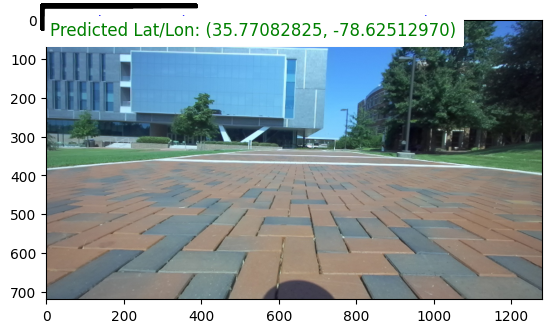

In [46]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from PIL import Image
import random

# Assuming you have already defined COCOGeolocationDataset and LatLonModel

# Load pre-trained LatLonModel
lat_lon_model = LatLonModel()
lat_lon_model.load_state_dict(torch.load("lat_lon_model_gps.pt", weights_only=True))
lat_lon_model.eval()  # Set the model to evaluation mode

# Create the dataset and split it
lat_lon_dataset = COCOGeolocationDataset(coco_file_path, images_dir)
train_size = int(0.8 * len(lat_lon_dataset))
test_size = len(lat_lon_dataset) - train_size

lat_lon_train_dataset, lat_lon_test_dataset = random_split(lat_lon_dataset, [train_size, test_size])
lat_lon_train_dataloader = DataLoader(lat_lon_train_dataset, batch_size=10, shuffle=True)
lat_lon_test_dataloader = DataLoader(lat_lon_test_dataset, batch_size=10, shuffle=False)

# Evaluate the LatLonModel on the test set
all_predictions = []
all_targets = []
image_paths = []

with torch.no_grad():
    for inputs, targets, paths in lat_lon_test_dataloader:
        outputs = lat_lon_model(inputs)
        all_predictions.append(outputs)
        all_targets.append(targets)
        image_paths.extend(paths)

# Combine all predictions and targets
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate Mean Squared Error
criterion = nn.MSELoss()
mse = criterion(all_predictions, all_targets).item()
print(f'Mean Squared Error on Test Set: {mse:.8f}')

rmse = math.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse:.8f}')

# # Conversion factors (meters per degree)
# meters_per_deg_lat = 111320  # Roughly constant
# meters_per_deg_lon = 111320 * math.cos(math.radians(central_latitude))

# # Convert RMSE to meters for latitude and longitude
# rmse_lat_meters = rmse * meters_per_deg_lat
# rmse_lon_meters = rmse * meters_per_deg_lon

# print(f'RMSE for Latitude in meters: {rmse_lat_meters:.8f}')
# print(f'RMSE for Longitude in meters: {rmse_lon_meters:.8f}')

# # If you want to consider the combined RMSE in meters (latitude + longitude together)
# combined_rmse_meters = math.sqrt(rmse_lat_meters**2 + rmse_lon_meters**2)
# print(f'Combined RMSE in meters: {combined_rmse_meters:.8f}')

def calculate_mean_error_in_meters(predictions, targets):
    total_distance = 0.0
    num_samples = len(predictions)
    # print(num_samples)

    for i in range(num_samples):
        predicted_lat, predicted_lon = predictions[i].numpy()
        actual_lat, actual_lon = targets[i].numpy()
        
        actual_lat = actual_lat / 1000.0 + 35.7
        actual_lon = actual_lon / -1000.0 - 78.6
        predicted_lat = predicted_lat / 1000.0 + 35.7
        predicted_lon = predicted_lon / -1000.0 - 78.6
        
        
        # Calculate the Haversine distance between predicted and actual lat/lon
        distance = haversine(actual_lat, actual_lon, predicted_lat, predicted_lon)
        # print(distance)
        # Accumulate the distance
        total_distance += distance
    # Calculate the mean error in meters
    mean_error = total_distance / num_samples
    return mean_error

# Calculate the mean error in meters on the test set
mean_error_in_meters = calculate_mean_error_in_meters(all_predictions, all_targets)
print(f'Mean Error in Meters on Test Set: {mean_error_in_meters:.8f}')


# Calculate latitude and longitude RMSE separately
lat_rmse = torch.sqrt(torch.mean((all_predictions[:, 0] - all_targets[:, 0]) ** 2)).item()
lon_rmse = torch.sqrt(torch.mean((all_predictions[:, 1] - all_targets[:, 1]) ** 2)).item()

mean_latitude = all_targets[:, 0].mean().item()
# Convert RMSE to meters
latitude_meters = lat_rmse * 111320  # 111.32 km per degree
longitude_meters = lon_rmse * 111320 * math.cos(math.radians(mean_latitude))

total_error_meters = math.sqrt(latitude_meters ** 2 + longitude_meters ** 2)

# print(f'RMSE in Meters: {total_error_meters:.8f}')

# Function to visualize random test images with bounding boxes and geolocation labels
def visualize_random_predictions(test_dataset, all_predictions, num_images=50):
    indices = random.sample(range(len(test_dataset)), num_images)
    average = 0
    for i in indices:
        bounding_box, geolocation, image_path = test_dataset[i]
        predicted_output = all_predictions[i].cpu().numpy()
        
        # Latitude and longitude
        predicted_lat_lon = predicted_output[:2]
        actual_lat_lon = geolocation[:2].numpy()

        # Load and plot the image
        image = Image.open(image_path)
        plt.imshow(image)
        
        # Plot all bounding boxes from the COCO annotations for this image
        num_classes = 9  # Adjust this number based on your dataset
        max_instances_per_class = 2
        class_names = ['sign', 'FW', 'HUNT', 'Oval', 'engineering-building', 'security-station', 'sign', 'street-lamp', 'trashcan']  # Replace with actual class names

        for class_id in range(num_classes):
            for instance in range(max_instances_per_class):
                start_index = (class_id * max_instances_per_class + instance) * 4
                x, y, w, h = bounding_box[start_index:start_index+4].numpy()
                if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                    rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
                    plt.gca().add_patch(rect)
                    plt.text(x, y, f'{class_names[class_id]}', color='yellow', fontsize=10, backgroundcolor='black')
        print(f" predicted {predicted_lat_lon}")
        actual_lat_lon[0] = actual_lat_lon[0] / 1000.0 + 35.7
        actual_lat_lon[1] = actual_lat_lon[1] / -1000.0 - 78.6
        predicted_lat_lon[0] = predicted_lat_lon[0] / 1000.0 + 35.7
        predicted_lat_lon[1] = predicted_lat_lon[1] / -1000.0 - 78.6
        distance = haversine(actual_lat_lon[0], actual_lat_lon[1], predicted_lat_lon[0], predicted_lat_lon[1])
        
        # Display geolocations with clear labels (latitude and longitude)
        plt.text(10, 20, f"Actual Lat/Lon: ({actual_lat_lon[0]:.8f}, {actual_lat_lon[1]:.8f})", color='blue', fontsize=12, backgroundcolor='white')
        plt.text(10, 40, f"Predicted Lat/Lon: ({predicted_lat_lon[0]:.8f}, {predicted_lat_lon[1]:.8f})", color='green', fontsize=12, backgroundcolor='white')
        
        print(f"Actual Lat/Lon: ({actual_lat_lon[0]:.8f}, {actual_lat_lon[1]:.8f})")
        print(f"Predicted Lat/Lon: ({predicted_lat_lon[0]:.8f}, {predicted_lat_lon[1]:.8f})")
        print(f"Meters Error: {distance}")
        average += distance
        
        
        # plt.title('Random Test Image')
        # plt.axis('off')73594893
        # plt.show()
    print(average/float(num_images))

# Visualize random images from the test set
visualize_random_predictions(lat_lon_test_dataset, all_predictions, num_images=50)


In [21]:
# # Result of compass model
# import random
# import torch
# import math
# import matplotlib.pyplot as plt
# from PIL import Image

# # Evaluate the compass model on the test set
# compass_model.eval()
# compass_predictions = []
# compass_targets = []
# compass_image_paths = []

# # Use compass_test_dataloader for evaluation
# with torch.no_grad():
#     for inputs, targets, paths in compass_test_dataloader:
#         outputs = compass_model(inputs)
#         compass_predictions.append(outputs)
#         compass_targets.append(targets)
#         compass_image_paths.extend(paths)

# # Combine all predictions and targets for compass orientation
# compass_predictions = torch.cat(compass_predictions, dim=0)
# compass_targets = torch.cat(compass_targets, dim=0)

# # Calculate Mean Squared Error for compass orientation
# compass_mse = criterion(compass_predictions, compass_targets).item()
# print(f'Mean Squared Error on Compass Test Set: {compass_mse:.8f}')

# compass_rmse = math.sqrt(compass_mse)
# print(f'Root Mean Squared Error (RMSE) on Compass Test Set: {compass_rmse:.8f}')

# # Function to visualize random test images with compass orientation labels
# def visualize_random_compass_predictions(test_dataset, compass_predictions, num_images=5):
#     indices = random.sample(range(len(test_dataset)), num_images)
    
#     for i in indices:
#         bounding_box, geolocation, image_path = test_dataset[i]
#         predicted_orientation = compass_predictions[i].cpu().numpy()[0]
#         actual_orientation = geolocation[0].item()

#         # Load and plot the image
#         image = Image.open(image_path)
#         plt.imshow(image)
        
#         # Plot all bounding boxes from the COCO annotations for this image
#         num_classes = 9  # Assuming 9 classes, adjust if necessary
#         max_instances_per_class = 2  # Assuming a maximum of 2 instances per class
#         class_names = ['sign', 'FW', 'HUNT', 'Oval', 'engineering-building', 'security-station', 'sign', 'street-lamp', 'trashcan']  # Replace with actual class names

#         for class_id in range(num_classes):
#             for instance in range(max_instances_per_class):
#                 start_index = (class_id * max_instances_per_class + instance) * 4
#                 x, y, w, h = bounding_box[start_index:start_index+4].numpy()
#                 if w > 0 and h > 0:  # Ensure valid bounding box dimensions
#                     rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
#                     plt.gca().add_patch(rect)
#                     plt.text(x, y, f'{class_names[class_id]}', color='yellow', fontsize=10, backgroundcolor='black')
        
#         # Display compass orientation with clear labels
#         plt.text(10, 20, f"Actual Compass: {actual_orientation:.8f}", color='blue', fontsize=12, backgroundcolor='white')
#         plt.text(10, 40, f"Predicted Compass: {predicted_orientation:.8f}", color='green', fontsize=12, backgroundcolor='white')
        
#         print(f"Actual Compass: {actual_orientation:.8f}")
#         print(f"Predicted Compass: {predicted_orientation:.8f}")
        
#         plt.title('Random Compass Test Image')
#         plt.axis('off')
#         plt.show()

# # Visualize random images from the compass test set
# visualize_random_compass_predictions(compass_test_dataset, compass_predictions, num_images=10)
